In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [2]:
# dataset
data = pd.read_csv('nhis_2022.csv')

# Select important columns
selected_columns = ['CHEARTDIEV', 'AGE', 'SEX', 'BMICALC', 'HRSLEEP', 'HOURSWRK']
df = data[selected_columns]

In [3]:
# Function to clean invalid or special codes by replacing them with NaN
def clean_codes(x):
    return np.nan if x in [7,8,9,96,97,98,99,996,997,998,999] else x

# Apply the cleaning function to selected columns to handle missing value codes
for col in ['AGE', 'SEX', 'BMICALC', 'HRSLEEP', 'HOURSWRK']:
    df.loc[:, col] = df[col].apply(clean_codes)

# Recode the 'CHEARTDIEV' column: 2 becomes 1 (has condition), 1 becomes 0 (no condition)
df.loc[:, 'CHEARTDIEV'] = df['CHEARTDIEV'].map({2: 1, 1: 0})

# Drop all rows that contain any NaN values 
df = df.dropna()

/var/folders/s6/grcp2pz16xx4l9v8xh1xx__c0000gn/T/ipykernel_87382/1457790857.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[61. 43. 12. ... 12. 61.  6.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].apply(clean_codes)
/var/folders/s6/grcp2pz16xx4l9v8xh1xx__c0000gn/T/ipykernel_87382/1457790857.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 1. 2. ... 2. 2. 1.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].apply(clean_codes)
/var/folders/s6/grcp2pz16xx4l9v8xh1xx__c0000gn/T/ipykernel_87382/1457790857.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan  6.  0. ...  0.  5.  0.]' has dtype incompatible with int64, please expli

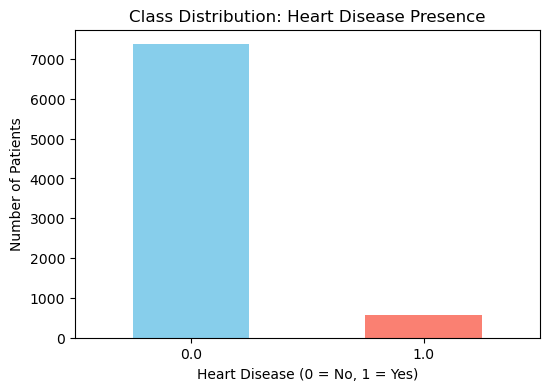

In [4]:
# class distribution
plt.figure(figsize=(6,4))
df['CHEARTDIEV'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Heart Disease Presence')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

In [5]:
# Ssplit and scale
X = df.drop('CHEARTDIEV', axis=1)
y = df['CHEARTDIEV']

# Split the dataset into training (70%) and testing (30%) sets with a fixed random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

# Initialize a standard scaler to normalize feature distributions (mean=0, std=1)
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data 
X_test_scaled = scaler.transform(X_test)

In [6]:
# SMOTE
sm = SMOTE(random_state=50)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Print out how many samples each class has after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after SMOTE:
CHEARTDIEV
0.0    5146
1.0    5146
Name: count, dtype: int64


In [7]:
# GridSearchCV for RBF SVM
# Create an SVM classifier with an RBF kernel; we set probability=True so we can later get probability scores
svc_rbf = SVC(kernel='rbf', probability=True)

# Define the grid of hyperparameters to try:
params_rbf = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto']
}

# Set up GridSearchCV to search over these hyperparameters using 5-fold cross-validation and accuracy as the metric
grid_rbf = GridSearchCV(svc_rbf, params_rbf, cv=5, scoring='accuracy')

# Fit the grid search on the SMOTE-resampled training data
grid_rbf.fit(X_train_resampled, y_train_resampled)

# Save the best-performing model from the grid search
best_rbf = grid_rbf.best_estimator_

In [8]:
# ROC curve and AUC
# Get the predicted probabilities for the positive class from the RBF SVM model
y_proba_rbf = best_rbf.predict_proba(X_test_scaled)[:, 1]

# Calculate the False Positive Rate and True Positive Rate for different threshold values
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_proba_rbf)

# Calculate the Area Under the Curve (AUC) — this gives us a single number summary of the ROC curve
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

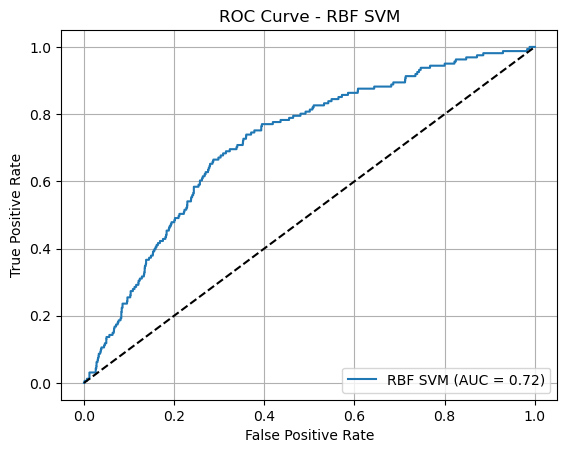

In [9]:
plt.figure()
plt.plot(fpr_rbf, tpr_rbf, label=f'RBF SVM (AUC = {roc_auc_rbf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RBF SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [10]:
# Training RBF SVM
rbf_svc = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svc.fit(X_train_resampled, y_train_resampled)


SVC(C=1)

In [11]:
# Predict and Evaluate
y_pred = rbf_svc.predict(X_test_scaled)

print("RBF SVM")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


RBF SVM
Accuracy: 0.6837463250734985
Confusion Matrix:
 [[1493  727]
 [  26  135]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.67      0.80      2220
         1.0       0.16      0.84      0.26       161

    accuracy                           0.68      2381
   macro avg       0.57      0.76      0.53      2381
weighted avg       0.93      0.68      0.76      2381



In [12]:
# decision boundary 
def plot_decision_boundary(var1, var2):
    # Pick two features we want to visualize and the target column
    X_vis = df[[var1, var2]]
    y_vis = df['CHEARTDIEV']
    
    # Split the data into training and test sets — we only use the training part for plotting
    X_train_vis, _, y_train_vis, _ = train_test_split(X_vis, y_vis, test_size=0.3, random_state=50)

    # Standardize the training data so the SVM model works better 
    scaler_vis = StandardScaler()
    X_train_vis_scaled = scaler_vis.fit_transform(X_train_vis)

    # Use SMOTE to create synthetic data points so that both classes are balanced
    sm_vis = SMOTE(random_state=50)
    X_train_vis_resampled, y_train_vis_resampled = sm_vis.fit_resample(X_train_vis_scaled, y_train_vis)

    # Train the Support Vector Machine with a non-linear (RBF) kernel
    svc_vis = SVC(kernel='rbf', C=1, gamma='scale')
    svc_vis.fit(X_train_vis_resampled, y_train_vis_resampled)

    # Make a grid of points that cover the entire feature space — we’ll predict on these to draw boundaries
    h = .02  # how detailed the grid is smaller = smoother
    x_min, x_max = X_train_vis_scaled[:, 0].min() - 1, X_train_vis_scaled[:, 0].max() + 1
    y_min, y_max = X_train_vis_scaled[:, 1].min() - 1, X_train_vis_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict class labels for all points in our grid
    Z = svc_vis.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Convert the grid points back to their original scale (undo the standardization)
    mesh = np.c_[xx.ravel(), yy.ravel()]
    mesh_real = scaler_vis.inverse_transform(mesh)
    xx_real = mesh_real[:, 0].reshape(xx.shape)
    yy_real = mesh_real[:, 1].reshape(yy.shape)

    plt.figure(figsize=(10,6))
    plt.contourf(xx_real, yy_real, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # Plot the real data points 
    # also converted back from scaled values
    real_points = scaler_vis.inverse_transform(X_train_vis_scaled)
    plt.scatter(real_points[:, 0], real_points[:, 1], c=y_train_vis, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'RBF SVM Decision Boundary ({var1} vs {var2}) with Real Scale and SMOTE')
    plt.show()


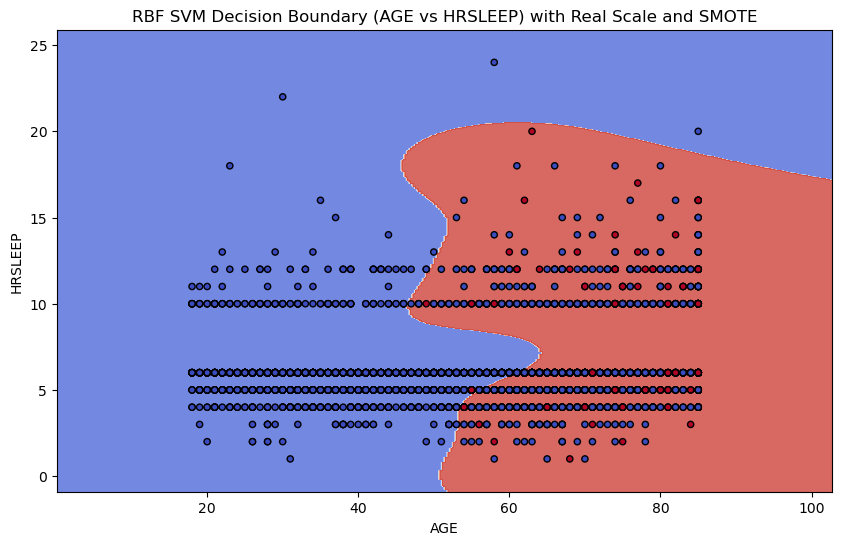

In [13]:
plot_decision_boundary('AGE', 'HRSLEEP')

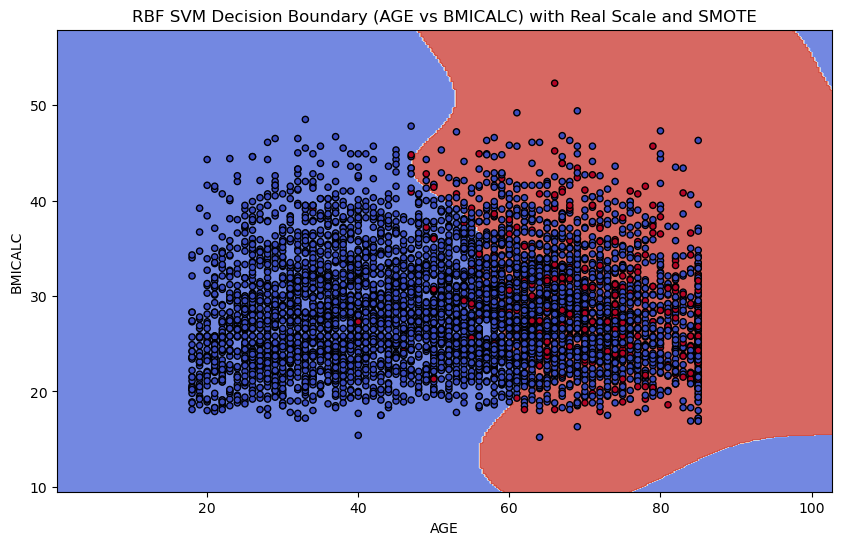

In [14]:
plot_decision_boundary('AGE', 'BMICALC')

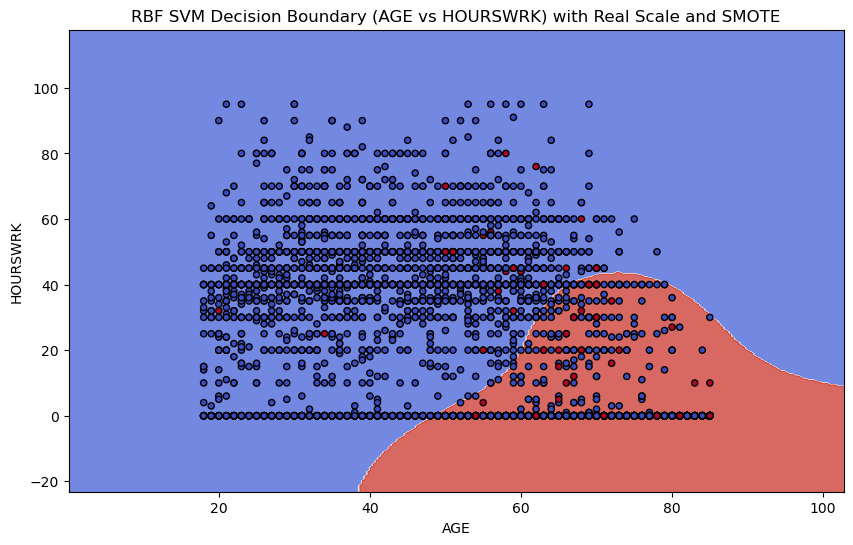

In [15]:
plot_decision_boundary('AGE', 'HOURSWRK')